In [1]:
import import_ipynb
from functionsModel import rank_simple_similarity # Similarities using raw values
from functionsModel import rank_keywords # Similarities using keywords
from functionsModel import rank_embeddings # Similarities using word embeddings
from preprocessText import preprocess_text # Function to process the text

import pandas as pd
import numpy as np

from tabulate import tabulate
import time

import gensim.downloader as api
from pytorch_pretrained_bert import BertTokenizer, BertModel

import matplotlib.pyplot as plt

import os
import pickle

importing Jupyter notebook from functionsModel.ipynb
importing Jupyter notebook from preprocessText.ipynb


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load & Preprocess Tables

## Data lake

In [4]:
# Load data lake
directory = 'Data/Evaluation/GitTables/DataLake/'
data_lake = []
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)
    table = pd.read_parquet(file)
    data_lake.append(table)


In [52]:
# Convert data lake tables into text
data_lake_text = [' '.join(table.apply(lambda row: ' '.join(row.astype(str)), axis=1)) for table in data_lake]

In [53]:
# Preprocess text of the tables in the data lake
data_lake_clean = [preprocess_text(table) for table in data_lake_text]

In [54]:
# Filter out tables with no text
data_lake_filtered = []
data_lake_indexes_filtered = []
for i,table_text in enumerate(data_lake_clean):
    if table_text != '':
        data_lake_filtered.append(table_text)
        data_lake_indexes_filtered.append(i)

In [55]:
def originalIndexes(filtered_indexes, list_original_indexes):
    # Function to go back to original indexes from the filtered ones
    original_indexes = []
    for index in filtered_indexes:
        original_indexes.append(list_original_indexes[index])
    return original_indexes

## Query

In [56]:
# Load query tables
directory = 'Data/Evaluation/GitTables/Queries/'
queries = []
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)
    table = pd.read_parquet(file)
    queries.append(table)

# Select query from the list
query_number = 1
query = queries[query_number]

In [57]:
# Convert the query table into text
query_text = ' '.join(query.apply(lambda row: ' '.join(row.astype(str)), axis=1))

In [58]:
# Preprocess the text of the query table
query_text_clean = preprocess_text(query_text)

# Run models on the input tables

In [59]:
def printResultsGitTables(indexes, similarities, keywordExtractionMethod = None, embeddingsMethod = None):
    # Funtion to print the output list of top-k most similar tables in a readible way
    if keywordExtractionMethod is not None:
        print("Keyword extraction method: {}".format(keywordExtractionMethod))
    if embeddingsMethod is not None:
        print("Embeddings method: {}".format(embeddingsMethod))

    print("-----")

    table = pd.DataFrame({'Index': indexes, 'Similarity': similarities}) 
    print(tabulate(table, headers=['Index', 'Similarity']))

## Load required models

In [60]:
# Word2Vec
model_Word2Vec = api.load("word2vec-google-news-300")

# BERT
model_name_Bert = 'bert-base-uncased'
tokenizer_Bert = BertTokenizer.from_pretrained(model_name_Bert)
model_Bert = BertModel.from_pretrained(model_name_Bert)
model_Bert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (den

## Run models

In [30]:
k = 10 # number of tables we want the model to output

Simple Similarity

In [61]:
start_time = time.time()

rank_simple_filtered, rank_simple_similarities = rank_simple_similarity(query, data_lake, k=len(data_lake))
rank_simple_indexes = originalIndexes(rank_simple_filtered, data_lake_indexes_filtered)
printResultsGitTables(rank_simple_indexes[:k], rank_simple_similarities[:k])

print("-----")
running_time_simple = time.time() - start_time
print("Running time: %s seconds" % round(running_time_simple,2))

-----
      Index    Similarity
--  -------  ------------
 0       13   4.60541e-06
 1       29   0
 2       28   0
 3        1   0
 4        2   0
 5        3   0
 6        4   0
 7        5   0
 8        6   0
 9        7   0
-----
Running time: 0.69 seconds


LDA

In [62]:
start_time = time.time()

keywordExtractionMethod = 'lda'

rank_lda_filtered, rank_lda_similarities, running_time_lda_noprocess = rank_keywords(query_text_clean, data_lake_filtered, keywordExtractionMethod, k = len(data_lake_filtered))
rank_lda_indexes = originalIndexes(rank_lda_filtered, data_lake_indexes_filtered)
printResultsGitTables(rank_lda_indexes[:k], rank_lda_similarities[:k], keywordExtractionMethod)

print("-----")
running_time_lda = time.time() - start_time
print("Running time: %s seconds" % round(running_time_lda,2))

Keyword extraction method: lda
-----
      Index    Similarity
--  -------  ------------
 0       25     0.0127758
 1       29     0
 2       13     0
 3        1     0
 4        2     0
 5        3     0
 6        4     0
 7        5     0
 8        6     0
 9        7     0
-----
Running time: 0.57 seconds


YAKE

In [63]:
start_time = time.time()

keywordExtractionMethod = 'yake'

rank_yake_filtered, rank_yake_similarities, running_time_yake_noprocess = rank_keywords(query_text_clean, data_lake_filtered, keywordExtractionMethod, k = len(data_lake_filtered))
rank_yake_indexes = originalIndexes(rank_yake_filtered, data_lake_indexes_filtered)
printResultsGitTables(rank_yake_indexes[:k], rank_yake_similarities[:k], keywordExtractionMethod)

print("-----")
running_time_yake = time.time() - start_time
print("Running time: %s seconds" % round(running_time_yake,2))

Keyword extraction method: yake
-----
      Index    Similarity
--  -------  ------------
 0       25     0.0443968
 1       29     0
 2       13     0
 3        1     0
 4        2     0
 5        3     0
 6        4     0
 7        5     0
 8        6     0
 9        7     0
-----
Running time: 5.96 seconds


LDA + Word2Vec

In [64]:
start_time = time.time()

keywordExtractionMethod = 'lda'
embeddingsMethod = 'word2vec'

rank_lda_word2vec_filtered, rank_lda_word2vec_similarities, running_time_lda_word2vec_noprocess = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Word2Vec, k = len(data_lake_filtered))
rank_lda_word2vec_indexes = originalIndexes(rank_lda_word2vec_filtered, data_lake_indexes_filtered)
printResultsGitTables(rank_lda_word2vec_indexes[:k], rank_lda_word2vec_similarities[:k], keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_lda_word2vec = time.time() - start_time
print("Running time: %s seconds" % round(running_time_lda_word2vec,2))

Keyword extraction method: lda
Embeddings method: word2vec
-----
      Index    Similarity
--  -------  ------------
 0       22   0.00635812
 1       16   0.00183565
 2       12   0.00168487
 3        3   0.0016017
 4       17   0.00156821
 5       27   0.00152831
 6       25   0.00149781
 7        9   0.0014894
 8       11   0.0011285
 9       20   0.000983174
-----
Running time: 0.43 seconds


LDA + BERT

In [65]:
start_time = time.time()

keywordExtractionMethod='lda'
embeddingsMethod = 'bert'

rank_lda_bert_filtered, rank_lda_bert_similarities, running_time_lda_bert_noprocess = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Bert, tokenizer_Bert, k = len(data_lake_filtered))
rank_lda_bert_indexes = originalIndexes(rank_lda_bert_filtered, data_lake_indexes_filtered)
printResultsGitTables(rank_lda_bert_indexes[:k], rank_lda_bert_similarities[:k], keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_lda_bert = time.time() - start_time
print("Running time: %s seconds" % round(running_time_lda_bert,2))

Keyword extraction method: lda
Embeddings method: bert
-----
      Index    Similarity
--  -------  ------------
 0       22    0.0275909
 1       28    0.00598635
 2        9    0.0059688
 3       15    0.00578676
 4       16    0.00578606
 5       11    0.00574687
 6       21    0.00573914
 7       14    0.00572749
 8       27    0.00571029
 9       13    0.00563699
-----
Running time: 9.87 seconds


YAKE + Word2Vec

In [66]:
start_time = time.time()

keywordExtractionMethod = 'yake'
embeddingsMethod = 'word2vec'

rank_yake_word2vec_filtered, rank_yake_word2vec_similarities, running_time_yake_word2vec_noprocess = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Word2Vec, k = len(data_lake_filtered))
rank_yake_word2vec_indexes = originalIndexes(rank_yake_word2vec_filtered, data_lake_indexes_filtered)
printResultsGitTables(rank_yake_word2vec_indexes[:k], rank_yake_word2vec_similarities[:k], keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_yake_word2vec = time.time() - start_time
print("Running time: %s seconds" % round(running_time_yake_word2vec,2))

Keyword extraction method: yake
Embeddings method: word2vec
-----
      Index    Similarity
--  -------  ------------
 0        7   2.78435e-05
 1       18   2.15092e-05
 2       26   1.64213e-05
 3       17   1.22809e-05
 4        3   8.95261e-06
 5       20   5.16089e-06
 6       12   4.27315e-06
 7        1   4.24927e-06
 8       25   4.12634e-06
 9       29   2.73403e-06
-----
Running time: 3.93 seconds


YAKE + BERT

In [67]:
start_time = time.time()

keywordExtractionMethod='yake'
embeddingsMethod = 'bert'

rank_yake_bert_filtered, rank_yake_bert_similarities, running_time_yake_bert_noprocess = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Bert, tokenizer_Bert, k = len(data_lake_filtered))
rank_yake_bert_indexes = originalIndexes(rank_yake_bert_filtered, data_lake_indexes_filtered)
printResultsGitTables(rank_yake_bert_indexes[:k], rank_yake_bert_similarities[:k], keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_yake_bert = time.time() - start_time
print("Running time: %s seconds" % round(running_time_yake_bert,2))

Keyword extraction method: yake
Embeddings method: bert
-----
      Index    Similarity
--  -------  ------------
 0        7   0.000239204
 1       26   0.000228924
 2       18   0.000172002
 3       17   0.000167875
 4        3   5.0749e-05
 5       29   4.70529e-05
 6       20   4.5623e-05
 7       12   4.28114e-05
 8        1   2.9946e-05
 9       25   2.92139e-05
-----
Running time: 12.51 seconds


# Analysis of the results

## Print output rankinngs

In [216]:
results_indexes = {
    'Simple': rank_simple_indexes[:k],
    'LDA': rank_lda_indexes[:k],
    'Yake': rank_yake_indexes[:k],
    'LDA + Word2Vec': rank_lda_word2vec_indexes[:k],
    'LDA + BERT': rank_lda_bert_indexes[:k],
    'Yake + Word2Vec': rank_yake_word2vec_indexes[:k],
    'Yake + BERT': rank_yake_bert_indexes[:k]
    }
print(tabulate(results_indexes, list(results_indexes.keys())))

  Simple    LDA    Yake    LDA + Word2Vec    LDA + BERT    Yake + Word2Vec    Yake + BERT
--------  -----  ------  ----------------  ------------  -----------------  -------------
       9     15       9                22            22                  7              7
       1      9      27                27            21                 18             26
      27     27       8                15            25                 26             18
       6      8      15                 7            11                 17             17
       4     29      29                11             2                  3              3
      20     13      13                 0             9                 29             29
      18      1       1                 1            16                 20             20
      22      2       2                21            20                  8             12
      28      3       3                20            15                 12              1
      10  

## NDCG

In [68]:
from sklearn.metrics import ndcg_score

labels = pd.read_excel("Data/Evaluation/GitTables/LabelledSimilarities.xlsx")

true_similarities = labels[labels['Query']==query_number]['Similarity']

In [69]:
def ndcg(true_similarities, rank_model_indexes, rank_model_similarities, k):
    similaties_by_index = sorted(tuple(zip(rank_model_indexes, rank_model_similarities)), key = lambda x: x[0])
    similarities = [x[1] for x in similaties_by_index]
    ndcg = ndcg_score(np.asarray([true_similarities]), np.asarray([similarities]), k=k)
    return ndcg

Simple similarity

In [70]:
ndcg_simple = ndcg(true_similarities, rank_simple_indexes, rank_simple_similarities, k)
print("NDCG:", ndcg_simple)

NDCG: 0.1498429972790824


LDA

In [71]:
ndcg_lda = ndcg(true_similarities, rank_lda_indexes, rank_lda_similarities, k)
print("NDCG:", ndcg_lda)

NDCG: 0.1498429972790824


YAKE

In [72]:
ndcg_yake = ndcg(true_similarities, rank_yake_indexes, rank_yake_similarities, k)
print("NDCG:", ndcg_yake)

NDCG: 0.1498429972790824


LDA + Word2Vec

In [73]:
ndcg_lda_word2vec = ndcg(true_similarities, rank_lda_word2vec_indexes, rank_lda_word2vec_similarities, k)
print("NDCG:", ndcg_lda_word2vec)

NDCG: 0.3868528072345415


LDA + BERT

In [74]:
ndcg_lda_bert = ndcg(true_similarities, rank_lda_bert_indexes, rank_lda_bert_similarities, k)
print("NDCG:", ndcg_lda_bert)

NDCG: 0.4415801103577825


YAKE + Word2Vec

In [75]:
ndcg_yake_word2vec = ndcg(true_similarities, rank_yake_word2vec_indexes, rank_yake_word2vec_similarities, k)
print("NDCG:", ndcg_yake_word2vec)

NDCG: 0.0


YAKE + BERT

In [76]:
ndcg_yake_bert = ndcg(true_similarities, rank_yake_bert_indexes, rank_yake_bert_similarities, k)
print("NDCG:", ndcg_yake_bert)

NDCG: 0.0


Print NCDG scores

In [77]:
ncdg_scores = {
    'Simple': ndcg_simple,
    'LDA': ndcg_lda,
    'Yake': ndcg_yake,
    'LDA + Word2Vec': ndcg_lda_word2vec,
    'LDA + BERT': ndcg_lda_bert,
    'Yake + Word2Vec': ndcg_yake_word2vec,
    'Yake + BERT': ndcg_yake_bert
    }

for model in ncdg_scores:
    print("{}: {}".format(model, ncdg_scores[model]))

Simple: 0.1498429972790824
LDA: 0.1498429972790824
Yake: 0.1498429972790824
LDA + Word2Vec: 0.3868528072345415
LDA + BERT: 0.4415801103577825
Yake + Word2Vec: 0.0
Yake + BERT: 0.0


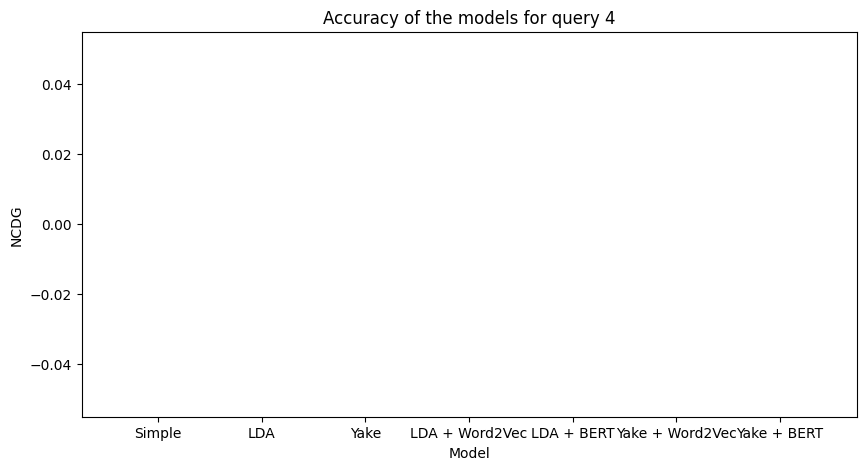

In [227]:
models = ncdg_scores.keys()
scores = ncdg_scores.values()

fig = plt.figure(figsize = (10, 5))
plt.bar(models, scores)
plt.xlabel("Model")
plt.ylabel("NCDG")
plt.title("Accuracy of the models for query {}".format(query_number))
plt.show()

## Efficiency

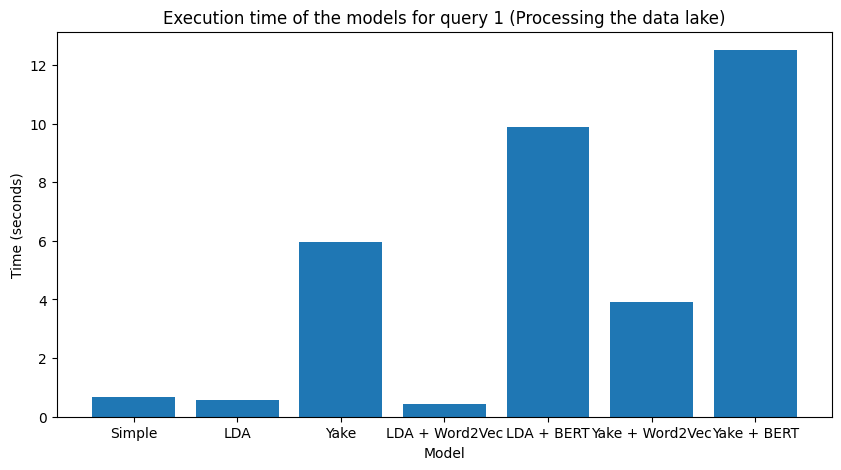

In [78]:
running_times = {
    'Simple': running_time_simple,
    'LDA': running_time_lda,
    'Yake': running_time_yake,
    'LDA + Word2Vec': running_time_lda_word2vec,
    'LDA + BERT': running_time_lda_bert,
    'Yake + Word2Vec': running_time_yake_word2vec,
    'Yake + BERT': running_time_yake_bert
}

models = list(running_times.keys())
times = list(running_times.values())
  
fig = plt.figure(figsize = (10, 5))
plt.bar(models, times)
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.title("Execution time of the models for query {} (Processing the data lake)".format(query_number))
plt.show()

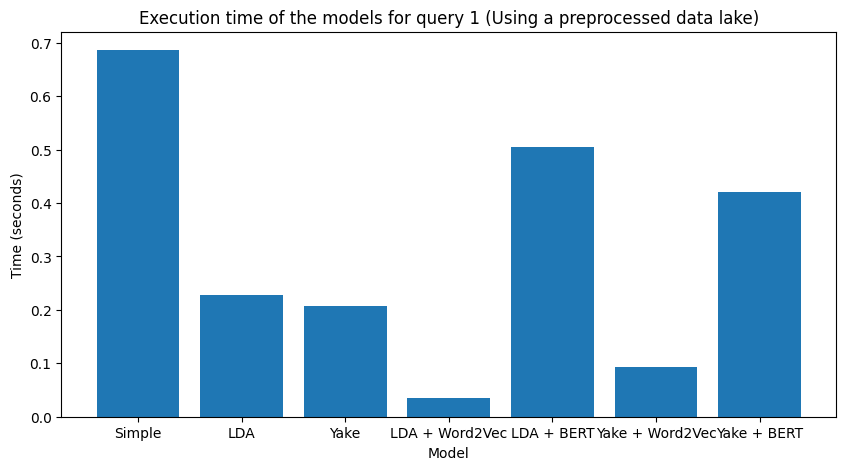

In [79]:
running_times_noprocess = {
    'Simple': running_time_simple,
    'LDA': running_time_lda_noprocess,
    'Yake': running_time_yake_noprocess,
    'LDA + Word2Vec': running_time_lda_word2vec_noprocess,
    'LDA + BERT': running_time_lda_bert_noprocess,
    'Yake + Word2Vec': running_time_yake_word2vec_noprocess,
    'Yake + BERT': running_time_yake_bert_noprocess
}

models = list(running_times_noprocess.keys())
times = list(running_times_noprocess.values())
  
fig = plt.figure(figsize = (10, 5))
plt.bar(models, times)
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.title("Execution time of the models for query {} (Using a preprocessed data lake)".format(query_number))
plt.show()

# Overall results

In [ ]:
# Load results already stored
if os.path.isfile("Data/Evaluation/GitTables/results.pickle"):
    with open("Data/Evaluation/GitTables/results.pickle", "rb") as fp:
        results = pickle.load(fp)
else:
    # If no results stored, initialize an empty list
    results = []

In [ ]:
results_query = {
    'query': query_number,
    'accuracy': ncdg_scores,
    'efficiency': running_times,
    'efficiency_noprocess': running_times_noprocess
}

# If there already exists the results for this query, we udpate them. Otherwise, we just append the results for the new query
matching_index = next((i for i, result in enumerate(results) if result['query'] == query_number), None)
if matching_index is not None:
    results[matching_index] = results_query
else:
    results.append(results_query)

In [82]:
with open("Data/Evaluation/GitTables/results.pickle", "wb") as fp:
    pickle.dump(results, fp)

## Average results

In [233]:
accuracies = {}
efficiencies = {}
efficiencies_noprocess = {}

for result in results:
    for model in result['accuracy']:
        if model not in accuracies:
            accuracies[model] = []
            efficiencies[model] = []
            efficiencies_noprocess[model] = []
        accuracies[model].append(result['accuracy'][model])
        efficiencies[model].append(result['efficiency'][model])
        efficiencies_noprocess[model].append(result['efficiency_noprocess'][model])

means_accuracies = {}
means_efficiencies = {}
means_efficiencies_noprocess = {}

for model, accuracy_list in accuracies.items():
    accuracy_mean = sum(accuracy_list) / len(accuracy_list)
    means_accuracies[model] = accuracy_mean

    efficiency_list = efficiencies[model]
    efficiency_mean = sum(efficiency_list) / len(efficiency_list)
    means_efficiencies[model] = efficiency_mean

    efficiency_noprocess_list = efficiencies_noprocess[model]
    efficiency_noprocess_mean = sum(efficiency_noprocess_list) / len(efficiency_noprocess_list)
    means_efficiencies_noprocess[model] = efficiency_noprocess_mean

print("Mean Accuracies:")
for model, mean in means_accuracies.items():
    print(f"{model}: {mean}")

print("\nMean Efficiencies (Processing the data lake):")
for model, mean in means_efficiencies.items():
    print(f"{model}: {mean}")

print("\nMean Efficiencies (Using a preprocessed data lake):")
for model, mean in means_efficiencies_noprocess.items():
    print(f"{model}: {mean}")

Mean Accuracies:
Simple: 0.1773935205567077
LDA: 0.21901592628483516
Yake: 0.21901592628483516
LDA + Word2Vec: 0.24840417236942763
LDA + BERT: 0.2357409431724477
Yake + Word2Vec: 0.03867056308831312
Yake + BERT: 0.0

Mean Efficiencies (Processing the data lake):
Simple: 1.1475549697875977
LDA: 0.49812984466552734
Yake: 7.512572813034057
LDA + Word2Vec: 0.4969149112701416
LDA + BERT: 15.561061191558839
Yake + Word2Vec: 7.419494915008545
Yake + BERT: 23.082517862319946

Mean Efficiencies (Using a preprocessed data lake):
Simple: 1.1475549697875977
LDA: 0.12410860061645508
Yake: 1.0019944190979004
LDA + Word2Vec: 0.07780680656433106
LDA + BERT: 0.6741039276123046
Yake + Word2Vec: 1.06443452835083
Yake + BERT: 1.6359790802001952


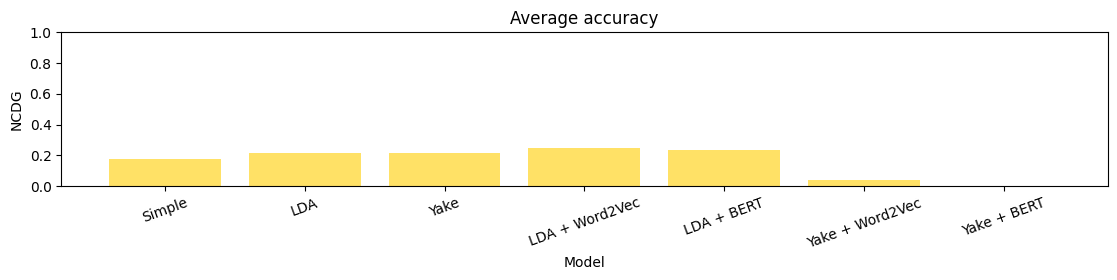

In [234]:
models = means_accuracies.keys()
accuracies = means_accuracies.values()

fig = plt.figure(figsize = (13.5, 2))
plt.bar(models, accuracies, color='#FFE166')
plt.xlabel("Model")
plt.xticks(rotation = 20) # Rotates X-Axis Ticks by 20-degrees
plt.ylabel("NCDG")
plt.ylim(0,1)
plt.title("Average accuracy")
plt.show()

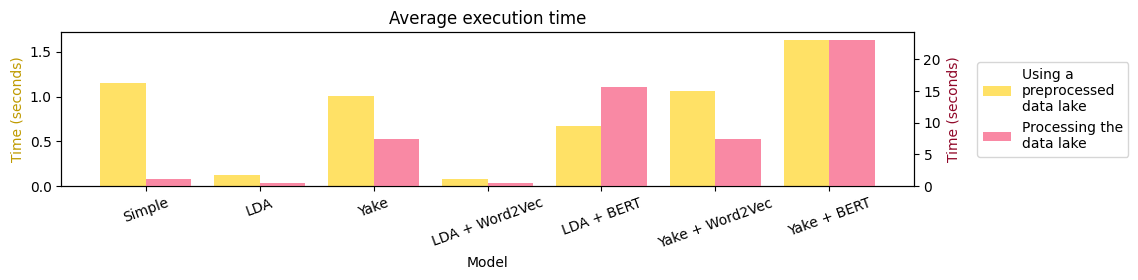

In [235]:
models = means_efficiencies.keys()
efficiencies = means_efficiencies.values()
efficiencies_noprocess = means_efficiencies_noprocess.values()

x = np.arange(len(models))
width = 0.4

fig, ax = plt.subplots(figsize = (11, 2))
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

bar1 = ax.bar(x-(width/2), efficiencies_noprocess, width=width, color='#FFE166')
bar2 = ax2.bar(x+(width/2), efficiencies, width=width, color='#F989A4')
ax.set_xlabel("Model")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation = 20) # Rotates X-Axis Ticks by 20-degrees
ax.set_ylabel("Time (seconds)")
ax.yaxis.label.set_color('#BF9A00')
ax2.set_ylabel("Time (seconds)")
ax2.yaxis.label.set_color('#900728')
ax.set_title("Average execution time")

bars = [bar1, bar2]
labels = ['Using a\npreprocessed\ndata lake', 'Processing the\ndata lake']
plt.legend(bars, labels, loc='center right', bbox_to_anchor=(1.26, 0.5))

plt.show()

## Results of a specific query

In [96]:
query_number = 0
results_query = [element for element in results if element['query'] == query_number][0]

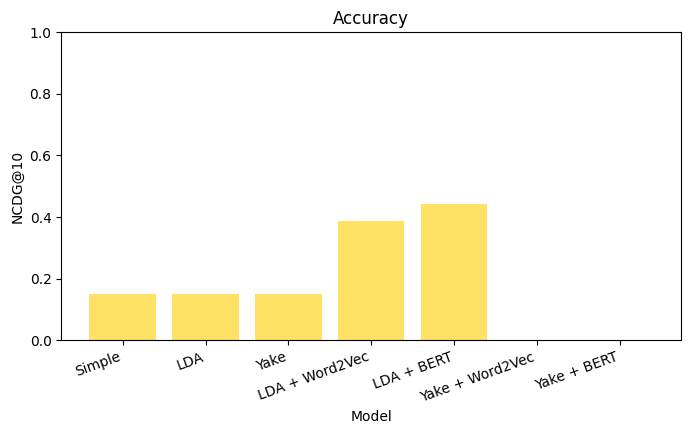

In [84]:
models = results_query['accuracy'].keys()
accuracies = results_query['accuracy'].values()

fig = plt.figure(figsize = (8, 4))
plt.bar(models, accuracies, color='#FFE166')
plt.xlabel("Model")
plt.xticks(rotation = 20, ha='right') # Rotates X-Axis Ticks and alighs the labels
plt.ylabel("NCDG@{}".format(k))
plt.ylim(0,1)
plt.title("Accuracy")
plt.show()

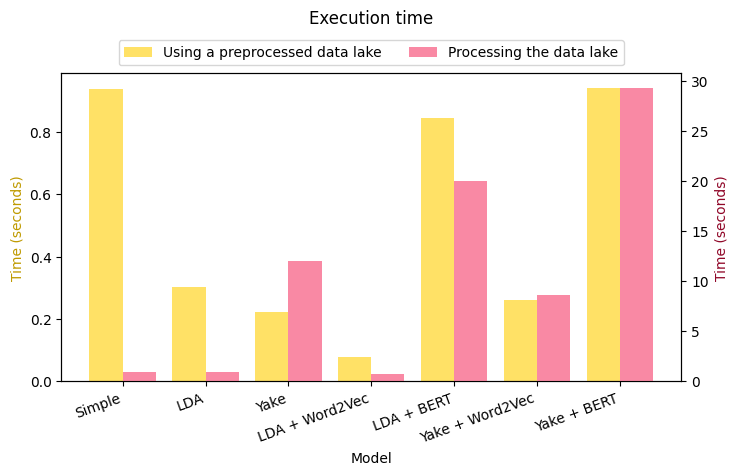

In [97]:
models = results_query['efficiency'].keys()
efficiencies = results_query['efficiency'].values()
efficiencies_noprocess = results_query['efficiency_noprocess'].values()

x = np.arange(len(models))
width = 0.4

fig, ax = plt.subplots(figsize = (8, 4))
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

bar1 = ax.bar(x-(width/2), efficiencies_noprocess, width=width, color='#FFE166')
bar2 = ax2.bar(x+(width/2), efficiencies, width=width, color='#F989A4')
ax.set_xlabel("Model")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation = 20, ha='right') # Rotates X-Axis Ticks by 20-degrees
ax.set_ylabel("Time (seconds)")
ax.yaxis.label.set_color('#BF9A00')
ax2.set_ylabel("Time (seconds)")
ax2.yaxis.label.set_color('#900728')
ax.set_title("Execution time\n\n")

bars = [bar1, bar2]
labels = ['Using a preprocessed data lake', 'Processing the data lake']
plt.legend(bars, labels, loc='upper center', ncol = 2, bbox_to_anchor=(0.5, 1.13))